In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import math
from lmfit import Model, Parameters
import matplotlib as mpl
from scipy import stats

mpl.rcParams['pdf.fonttype'] = 42


In [ ]:
plt.rcParams.update({
    'font.size': 16,          
    'axes.titlesize': 16,     
    'axes.labelsize': 16,     
    'xtick.labelsize': 33,    
    'ytick.labelsize': 33,    
    'legend.fontsize': 16     
})


# Read Data

In [ ]:
df = pd.read_excel('../../data/cases by cities/六安市逐周病例统计.xlsx')
df

,Date,Case
0,2023-01-01,0
1,2023-01-08,0
2,2023-01-15,0
3,2023-01-22,0
4,2023-01-29,0
...,...,...
260,2020-12-02,0
261,2020-12-09,0
262,2020-12-16,0
263,2020-12-23,0


In [ ]:
import pandas as pd


df['Date'] = pd.to_datetime(df['Date'])

years = df['Date'].dt.year.unique()

for year in years:
    globals()[f'df_{year}'] = df[df['Date'].dt.year == year]


I_2019 = df_2019['Case']
I_2020 = df_2020['Case']
I_2021 = df_2021['Case']
I_2022 = df_2022['Case']
I_2023 = df_2023['Case']

In [200]:
I_2019.sum()

106

# Model

## 2023

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 25
    # variables        = 4
    chi-square         = 259.111156
    reduced chi-square = 12.3386265
    Akaike info crit   = 66.4595330
    Bayesian info crit = 71.3350363
    R-squared          = 0.50071074
[[Variables]]
    beta0:  0.05148039 +/- 0.04608274 (89.52%) (init = 0.001)
    alpha:  4.51237979 +/- 5.22021741 (115.69%) (init = 2)
    T:      52 (fixed)
    S2_0:   94969.4873 +/- 303201.465 (319.26%) (init = 3000)
    S3_0:   1459.51041 +/- 2.0845e+09 (142819779.80%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0) = -0.9940
    C(alpha, S3_0) = +0.9391
    C(S2_0, S3_0)  = -0.3639
    C(beta0, S3_0) = +0.3179
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 171
    # data points      = 11
    # variables        = 3
    chi-square     

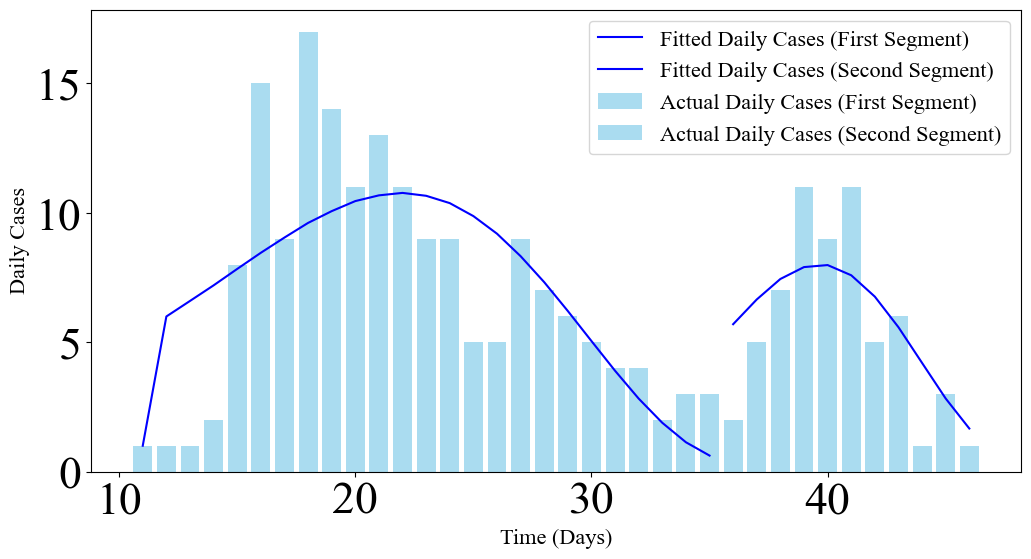

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters


def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))


def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]


observed_cases_1 = I_2023[10:35].reset_index(drop=True).values  
observed_cases_2 = I_2023[35:46].reset_index(drop=True).values  
t_days_1 = np.arange(11, 36)  
t_days_2 = np.arange(35, 47)  
t_days_3 = np.arange(36, 47)  


def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4342999  
    I1_0 = 1        
    E1_0 = 0        
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00572
    dr1 = 0.00961
    κ = 1
    p = 0.043
    f = 0.038298
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))


model = Model(model_fit)


params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  
params.add('alpha', value=2, min=-10, max=10)       
params.add('T', value=52, vary=False)               
params.add('S2_0', value=3000, min=1000, max=1e5)  
params.add('S3_0', value=1000, min=1000, max=1e4)  


result_1 = model.fit(observed_cases_1, params, t=t_days_1)


S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value


initial_state_segment1 = [
    4342999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00572
dr1 = 0.00961
κ = 1
p = 0.043
f = 0.038298
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))


final_state_segment1 = result_segment1.y[:, -1]


def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00572
    dr1 = 0.00961
    κ = 1
    p = 0.043
    f = 0.038298
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt


model_segment2 = Model(model_fit_segment2)


params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  
# params_segment2.add('T', value=52, vary=False) 


result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)


print(result_1.fit_report())
print(result_2.fit_report())


plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2023 的中位数: 3.2617169335778025
R_2023 的中位数: 0.03455212256998326


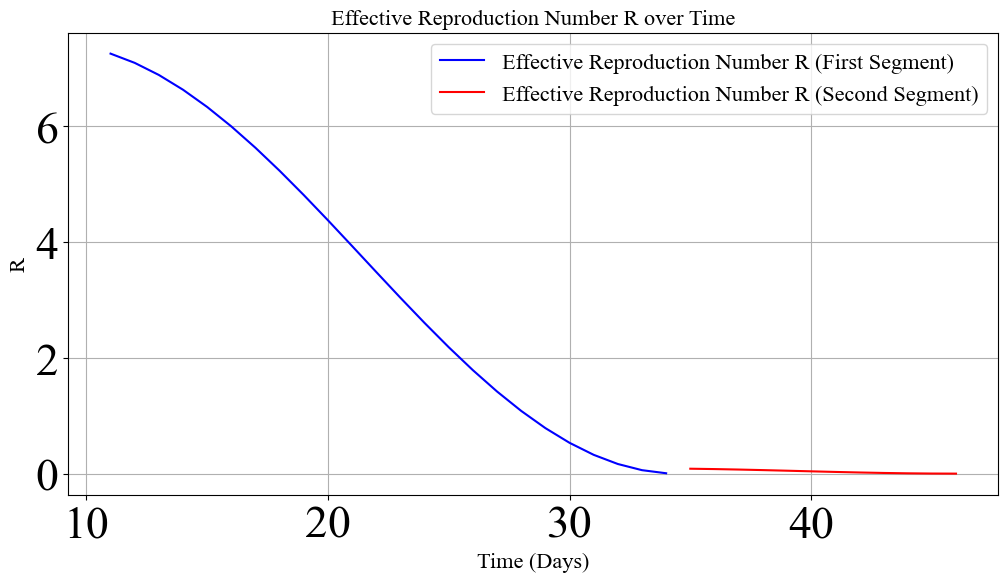

In [ ]:
N1 = 4343000


def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    

    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    

    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    

    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(11, 35)

R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics


median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2023 的中位数:", median_R_1)
print("R_2023 的中位数:", median_R_2)


plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

result_2023 = np.concatenate((result_1.best_fit, result_2.best_fit))


observed_cases_2023 = I_2023[10:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2023


y_pred = result_2023  


mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')


rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')


mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')


mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')


r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 8.665761132756128
RMSE: 2.9437664874707927
R-squared: 0.5336616522836881
MAE: 2.097246759593754
MAPE: 72.25978403912663%


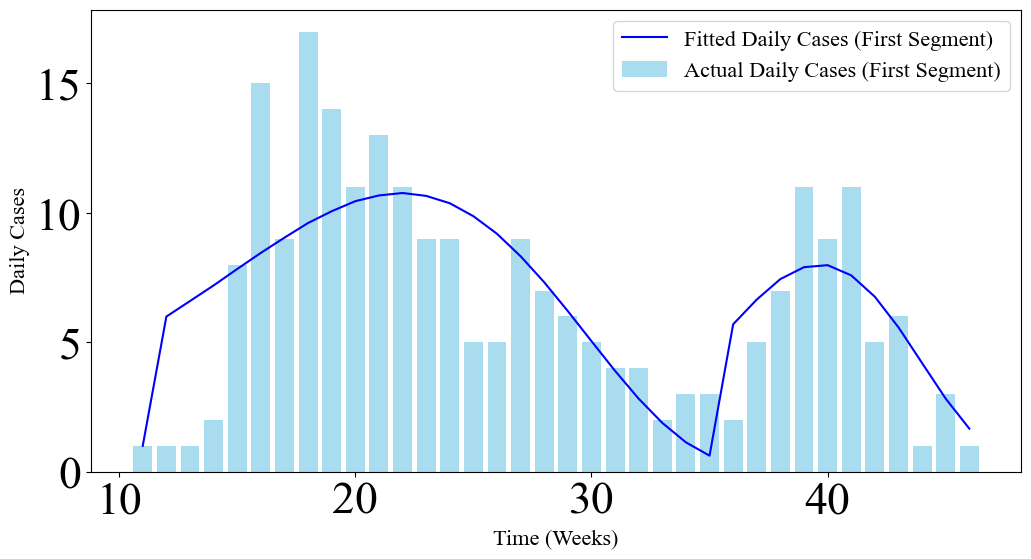

皮尔森相关系数：0.7317339091445032
p值：3.9675431544657476e-07


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(11, 47), observed_cases_2023, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(11, 47), result_2023, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Luan/2023.pdf', format='pdf')
plt.show()


from scipy.stats import pearsonr


corr, p_value = pearsonr(observed_cases_2023, result_2023)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

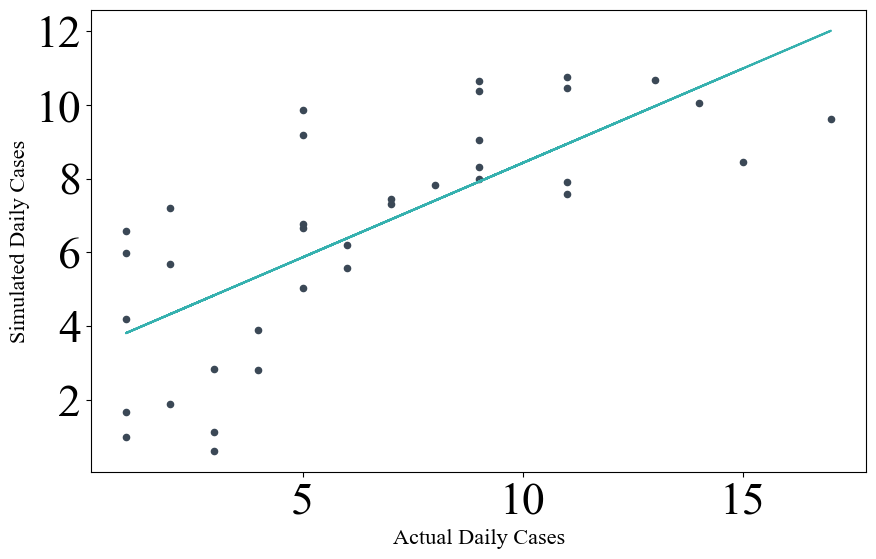

R²：0.5354345137918961


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  


I_obs = np.array(observed_cases_2023)
predicted_cases = np.array(result_2023)


model = LinearRegression()


model.fit(I_obs.reshape(-1, 1), predicted_cases)


y_pred = model.predict(I_obs.reshape(-1, 1))


r2 = r2_score(predicted_cases, y_pred)


plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Luan/2023.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

R_2023 的中位数: 0.9354511164118238
R_2023 的平均数为: 2.2816662189524117


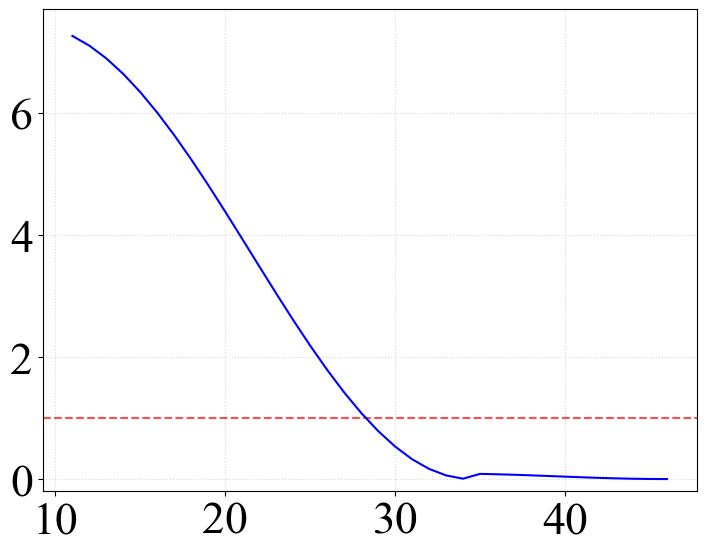

In [ ]:
R_2023 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2023).to_excel('../../outcome/Result/Fit/Luan/R_2023.xlsx', index=False)

median_R_23 = statistics.median(R_2023)
print("R_2023 的中位数:", median_R_23)
average_R = np.mean(R_2023)
print(f"R_2023 的平均数为: {average_R}")

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 

plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')

plt.ylim(-0.2, 7.7)
plt.yticks(np.arange(0, 7.1, 2))  
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.plot(np.arange(11, 47), R_2023, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Luan/R_2023.pdf', format='pdf')
plt.show()

## 2022

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 24
    # variables        = 4
    chi-square         = 145.549155
    reduced chi-square = 7.27745773
    Akaike info crit   = 51.2590408
    Bayesian info crit = 55.9712561
    R-squared          = 0.27088714
[[Variables]]
    beta0:  0.03220283 +/- 0.03098143 (96.21%) (init = 0.001)
    alpha:  3.50122863 +/- 13.9801173 (399.29%) (init = 2)
    T:      52 (fixed)
    S2_0:   99844.1422 +/- 266015.684 (266.43%) (init = 3000)
    S3_0:   1000.57004 +/- 3.9148e+10 (3912570325.74%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = -0.9770
    C(beta0, S2_0)  = -0.9712
    C(beta0, alpha) = -0.4235
    C(beta0, S3_0)  = +0.2722
    C(alpha, S2_0)  = +0.2643
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 107
    # data points      = 14
    # varia

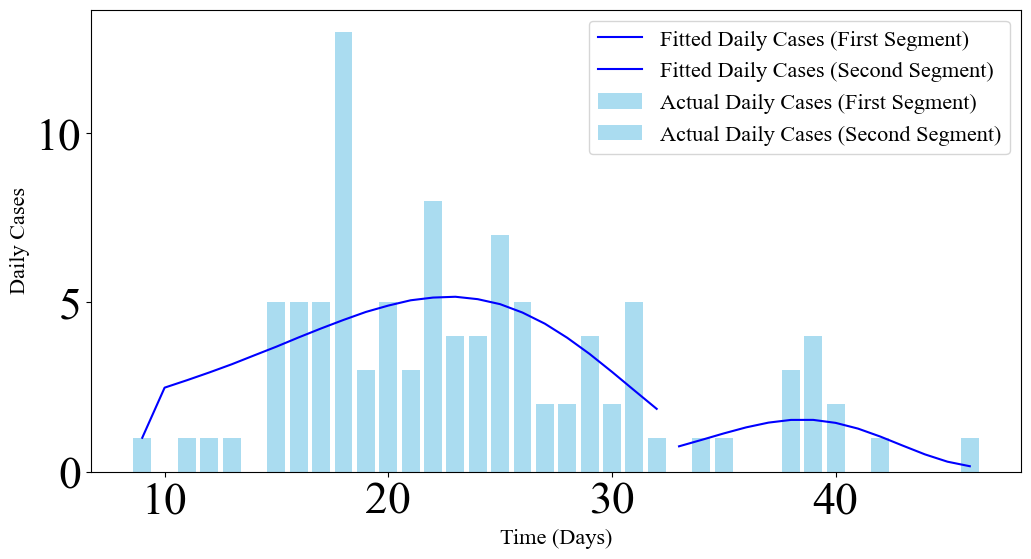

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters


def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))


def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]


observed_cases_1 = I_2022[8:32].reset_index(drop=True).values  
observed_cases_2 = I_2022[32:46].reset_index(drop=True).values  
t_days_1 = np.arange(9, 33)  
t_days_2 = np.arange(32, 47)  
t_days_3 = np.arange(33, 47)  


def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4378999  
    I1_0 = 1        
    E1_0 = 0        
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00614
    dr1 = 0.00901
    κ = 1
    p = 0.043
    f = 0.04
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))


model = Model(model_fit)


params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  
params.add('alpha', value=2, min=-10, max=10)       
params.add('T', value=52, vary=False)               
params.add('S2_0', value=3000, min=1000, max=1e5)  
params.add('S3_0', value=1000, min=1000, max=1e4)  


result_1 = model.fit(observed_cases_1, params, t=t_days_1)


S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value


initial_state_segment1 = [
    4378999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00614
dr1 = 0.00901
κ = 1
p = 0.043
f = 0.04
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))


final_state_segment1 = result_segment1.y[:, -1]


def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00614
    dr1 = 0.00901
    κ = 1
    p = 0.043
    f = 0.04
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt


model_segment2 = Model(model_fit_segment2)


params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  
# params_segment2.add('T', value=52, vary=False) 


result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)


print(result_1.fit_report())
print(result_2.fit_report())


plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2022 的中位数: 2.537871579093768
R_2022 的中位数: 0.020409556962515167


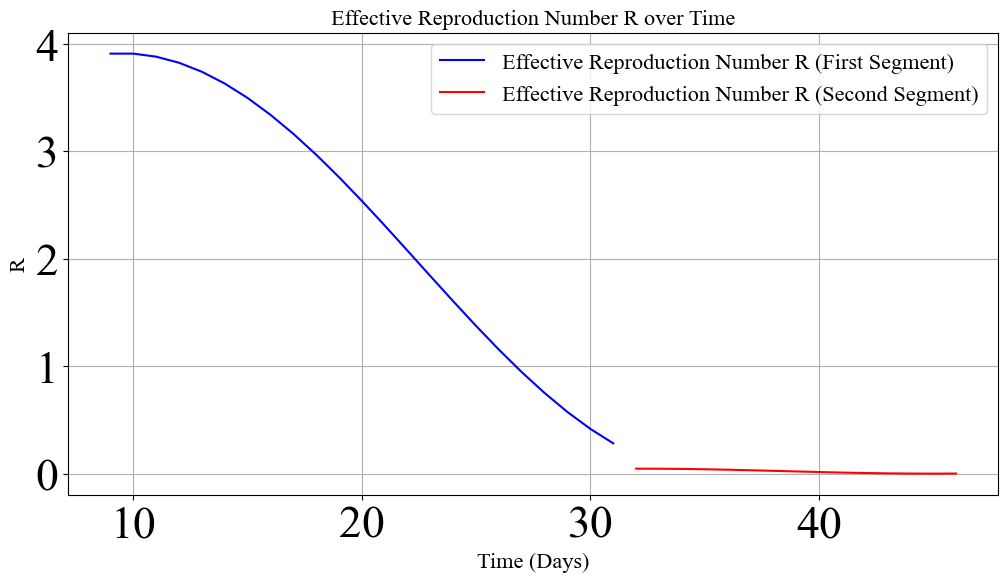

In [ ]:
N1 = 4379000



def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    

    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    

    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    

    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(9, 32)

R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics


median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2022 的中位数:", median_R_1)
print("R_2022 的中位数:", median_R_2)


plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

result_2022 = np.concatenate((result_1.best_fit, result_2.best_fit))


observed_cases_2022 = I_2022[8:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2022


y_pred = result_2022  


mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')


rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')


mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')


mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 4.257471829247206
RMSE: 2.0633642017945366
R-squared: 0.4320224204145451
MAE: 1.4700141299474536
MAPE: inf%


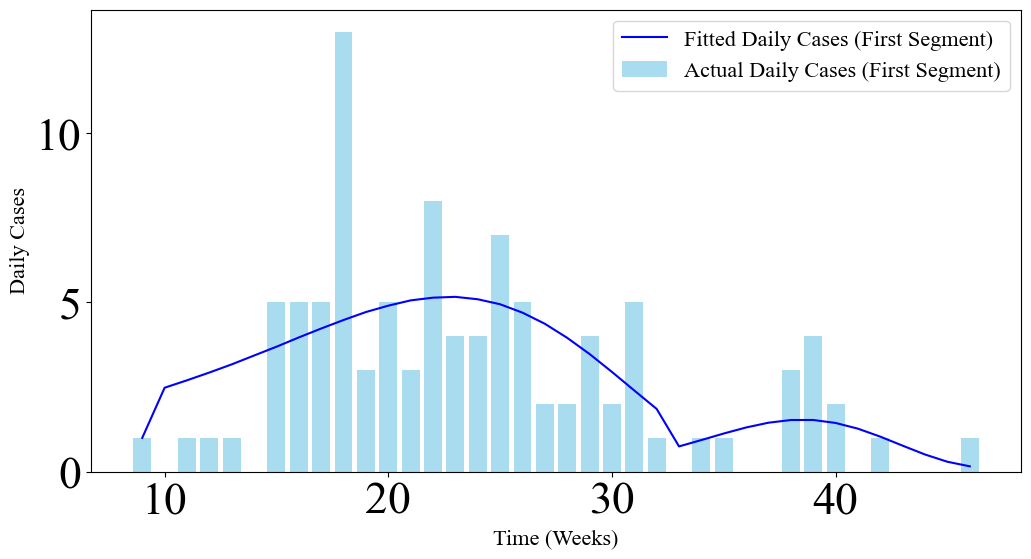

皮尔森相关系数：0.6621493754109444
p值：5.960746878532002e-06


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(9, 47), observed_cases_2022, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(9, 47), result_2022, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Luan/2022.pdf', format='pdf')
plt.show()


from scipy.stats import pearsonr


corr, p_value = pearsonr(observed_cases_2022, result_2022)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

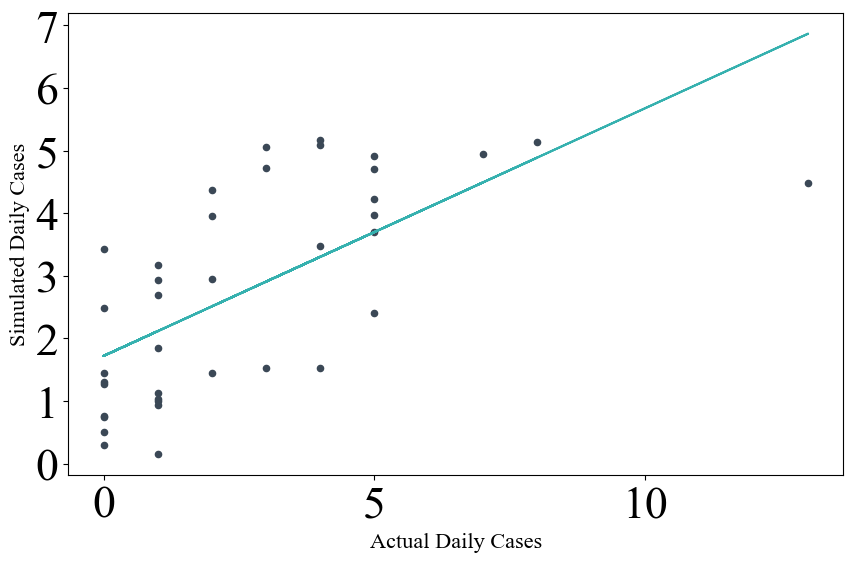

R²：0.43844179535710404


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  


I_obs = np.array(observed_cases_2022)
predicted_cases = np.array(result_2022)


model = LinearRegression()


model.fit(I_obs.reshape(-1, 1), predicted_cases)


y_pred = model.predict(I_obs.reshape(-1, 1))


r2 = r2_score(predicted_cases, y_pred)


plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Luan/2022.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 0.846731716387298
R_2023 的平均数为: 1.441939299697806


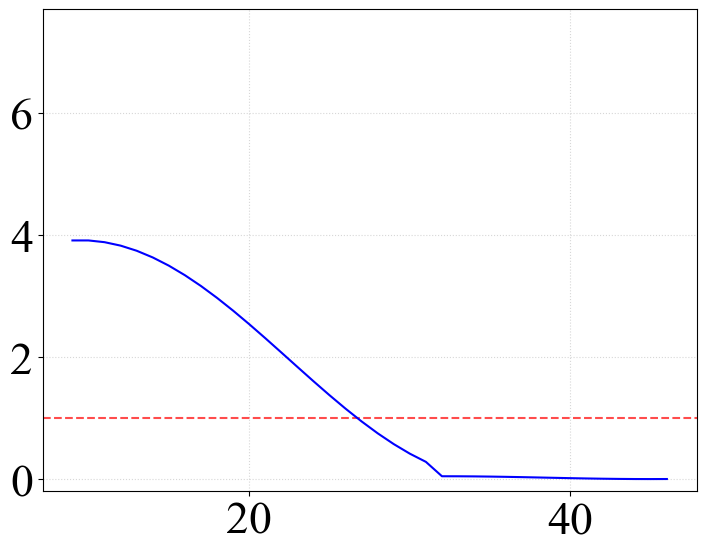

In [ ]:
R_2022 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2022).to_excel('../../outcome/Result/Fit/Luan/R_2022.xlsx', index=False)

import statistics

median_Rt_11 = statistics.median(R_2022)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2022)
print(f"R_2023 的平均数为: {average_R}")


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 

plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')

plt.ylim(-0.2, 7.7)
plt.yticks(np.arange(0, 7.1, 2))  
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.plot(np.arange(9, 47), R_2022, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Luan/R_2022.pdf', format='pdf')
plt.show()

## 2021

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 103
    # data points      = 22
    # variables        = 4
    chi-square         = 38.4050919
    reduced chi-square = 2.13361622
    Akaike info crit   = 20.2572472
    Bayesian info crit = 24.6214170
    R-squared          = 0.15169476
[[Variables]]
    beta0:  0.03289248 +/- 0.05832868 (177.33%) (init = 0.001)
    alpha: -1.24774744 +/- 37.8616920 (3034.40%) (init = 2)
    T:      52 (fixed)
    S2_0:   9998.82486 +/- 82210.4709 (822.20%) (init = 3000)
    S3_0:   9923.74889 +/- 2.8997e+11 (2921976964.26%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, alpha) = -0.9802
    C(alpha, S3_0)  = +0.9553
    C(beta0, S3_0)  = -0.9093
    C(S2_0, S3_0)   = -0.6049
    C(alpha, S2_0)  = -0.3487
    C(beta0, S2_0)  = +0.2277
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # 

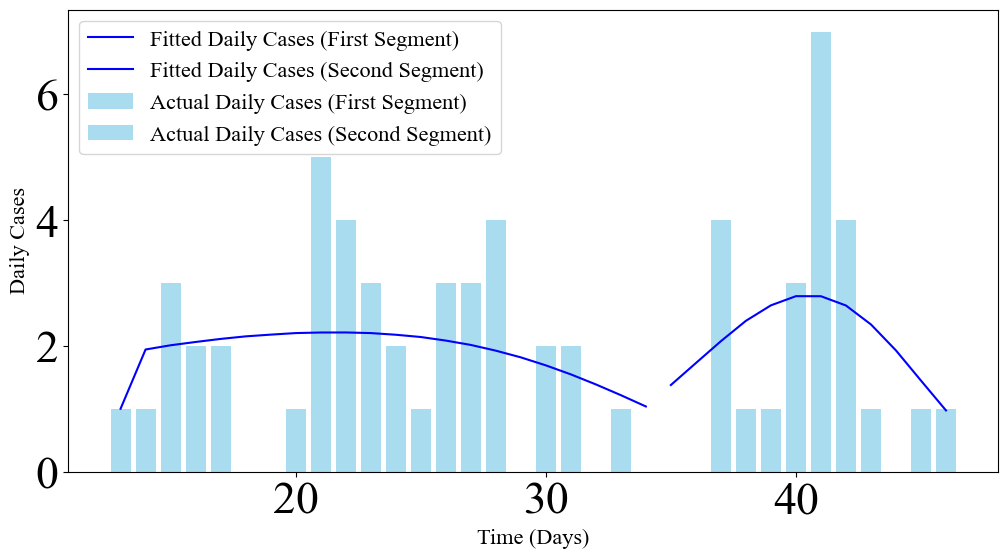

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters


def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))


def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]


observed_cases_1 = I_2021[12:34].reset_index(drop=True).values  
observed_cases_2 = I_2021[34:46].reset_index(drop=True).values  
t_days_1 = np.arange(13, 35)  
t_days_2 = np.arange(34, 47)  
t_days_3 = np.arange(35, 47)  


def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4404999  
    I1_0 = 1        
    E1_0 = 0        
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00719
    dr1 = 0.00873
    κ = 1
    p = 0.043
    f = 0
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))


model = Model(model_fit)


params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  
params.add('alpha', value=2, min=-10, max=10)       
params.add('T', value=52, vary=False)               
params.add('S2_0', value=3000, min=1000, max=1e4)  
params.add('S3_0', value=1000, min=1000, max=1e4)  



result_1 = model.fit(observed_cases_1, params, t=t_days_1)


S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value


initial_state_segment1 = [
    4404999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00719
dr1 = 0.00873
κ = 1
p = 0.043
f = 0
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))


final_state_segment1 = result_segment1.y[:, -1]


def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00719
    dr1 = 0.00873
    κ = 1
    p = 0.043
    f = 0
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt


model_segment2 = Model(model_fit_segment2)


params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  
# params_segment2.add('T', value=52, vary=False) 


result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)


print(result_1.fit_report())
print(result_2.fit_report())


plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2021 的中位数: 2.95155163637147
R_2021 的中位数: 0.08116464165367254


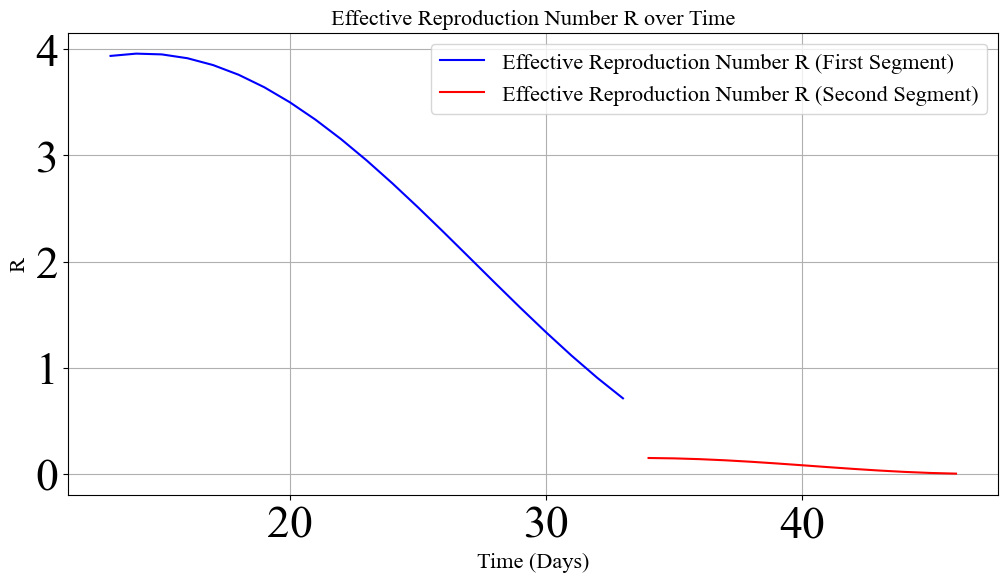

In [ ]:
N1 = 4405000



def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    

    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    

    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    

    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(13, 34)

R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics


median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2021 的中位数:", median_R_1)
print("R_2021 的中位数:", median_R_2)


plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

result_2021 = np.concatenate((result_1.best_fit, result_2.best_fit))


observed_cases_2021 = I_2021[12:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2021


y_pred = result_2021  


mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')


rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')


mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')


mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')


r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 2.264076329517447
RMSE: 1.5046847940739771
R-squared: 0.20034456555998514
MAE: 1.2093604305548828
MAPE: inf%


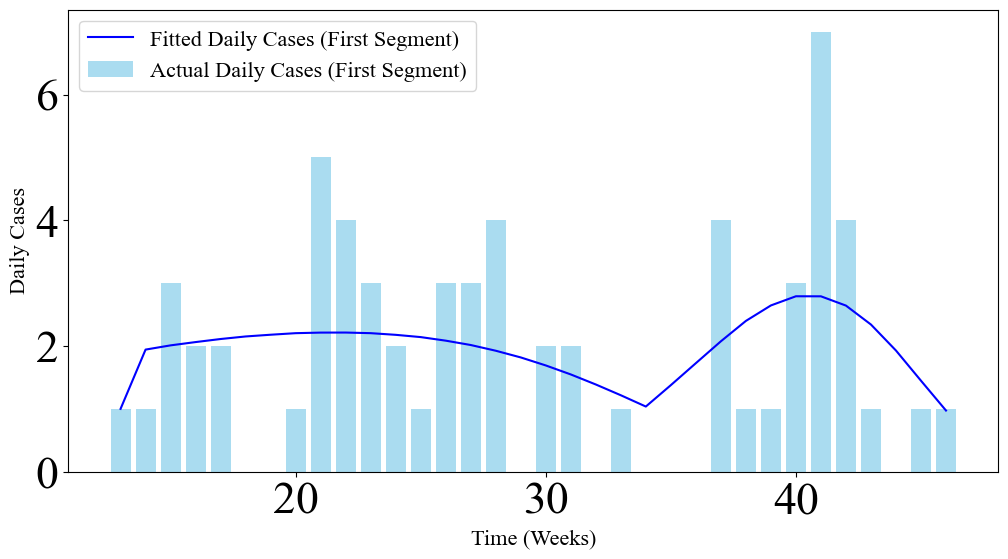

皮尔森相关系数：0.5023518923537827
p值：0.0024657647808972506


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(13, 47), observed_cases_2021, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(13, 47), result_2021, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Luan/2021.pdf', format='pdf')
plt.show()


from scipy.stats import pearsonr


corr, p_value = pearsonr(observed_cases_2021, result_2021)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

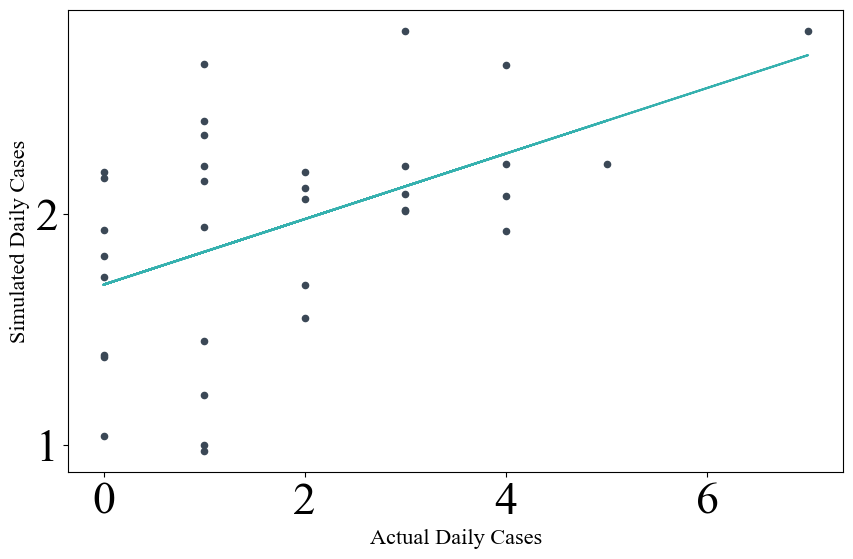

R²：0.25235742375142645


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  


I_obs = np.array(observed_cases_2021)
predicted_cases = np.array(result_2021)


model = LinearRegression()


model.fit(I_obs.reshape(-1, 1), predicted_cases)


y_pred = model.predict(I_obs.reshape(-1, 1))


r2 = r2_score(predicted_cases, y_pred)


plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Luan/2021.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.4484334101803258
R_2023 的平均数为: 1.7049309331984897


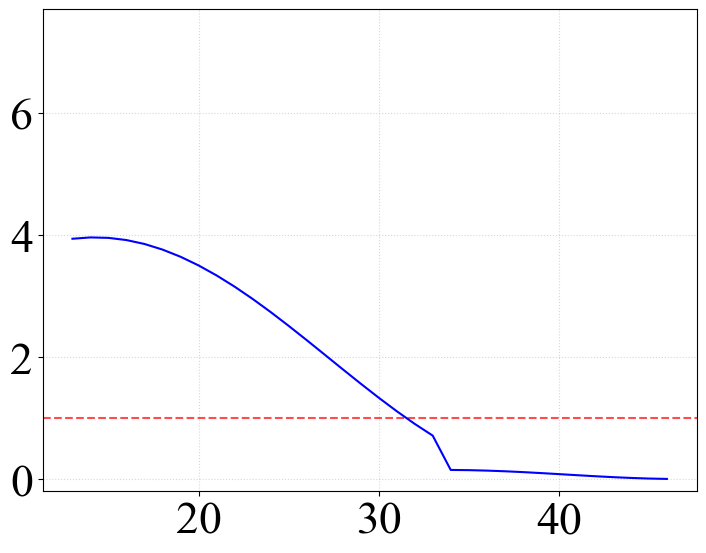

In [ ]:
R_2021 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2021).to_excel('../../outcome/Result/Fit/Luan/R_2021.xlsx', index=False)

import statistics

median_Rt_11 = statistics.median(R_2021)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2021)
print(f"R_2023 的平均数为: {average_R}")

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 

plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')

plt.ylim(-0.2, 7.7)
plt.yticks(np.arange(0, 7.1, 2))  
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.plot(np.arange(13, 47), R_2021, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Luan/R_2021.pdf', format='pdf')
plt.show()

## 2020

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 25
    # variables        = 4
    chi-square         = 88.4176075
    reduced chi-square = 4.21036226
    Akaike info crit   = 39.5798826
    Bayesian info crit = 44.4553859
    R-squared          = 0.31224636
[[Variables]]
    beta0:  0.02937700 +/- 0.02397724 (81.62%) (init = 0.001)
    alpha:  2.24674947 +/- 11.8958886 (529.47%) (init = 2)
    T:      52 (fixed)
    S2_0:   99997.7418 +/- 410117.849 (410.13%) (init = 3000)
    S3_0:   1058.42544 +/- 8.1927e+10 (7740422514.36%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = -0.9763
    C(beta0, S2_0)  = -0.9453
    C(beta0, alpha) = -0.5314
    C(beta0, S3_0)  = +0.3852
    C(alpha, S2_0)  = +0.2777
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 11
    # variab

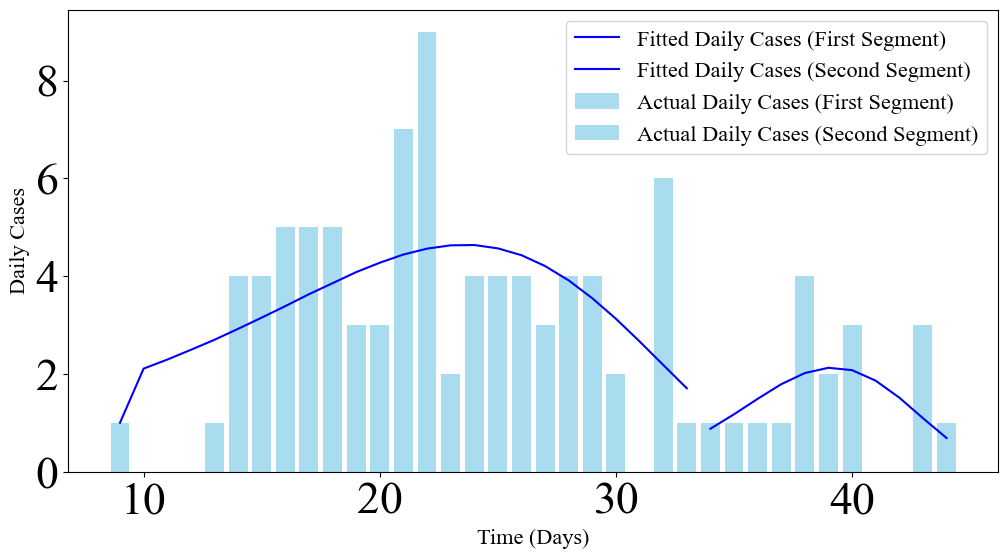

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters


def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))


def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]


observed_cases_1 = I_2020[8:33].reset_index(drop=True).values  
observed_cases_2 = I_2020[33:44].reset_index(drop=True).values  
t_days_1 = np.arange(9, 34)  
t_days_2 = np.arange(33, 45)  
t_days_3 = np.arange(34, 45)  


def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4395299  
    I1_0 = 1        
    E1_0 = 0        
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.01228
    dr1 = 0.00623
    κ = 1
    p = 0.043
    f = 0.012245
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))


model = Model(model_fit)


params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  
params.add('alpha', value=2, min=-10, max=10)       
params.add('T', value=52, vary=False)               
params.add('S2_0', value=3000, min=1000, max=1e5)  
params.add('S3_0', value=1000, min=1000, max=1e4)  


result_1 = model.fit(observed_cases_1, params, t=t_days_1)


S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value


initial_state_segment1 = [
    4395299, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.01228
dr1 = 0.00623
κ = 1
p = 0.043
f = 0.012245
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))


final_state_segment1 = result_segment1.y[:, -1]


def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.01228
    dr1 = 0.00623
    κ = 1
    p = 0.043
    f = 0.012245
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt


model_segment2 = Model(model_fit_segment2)


params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  
# params_segment2.add('T', value=52, vary=False) 


result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)


print(result_1.fit_report())
print(result_2.fit_report())


plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2020 的中位数: 2.529682356762347
R_2020 的中位数: 0.040028944576562635


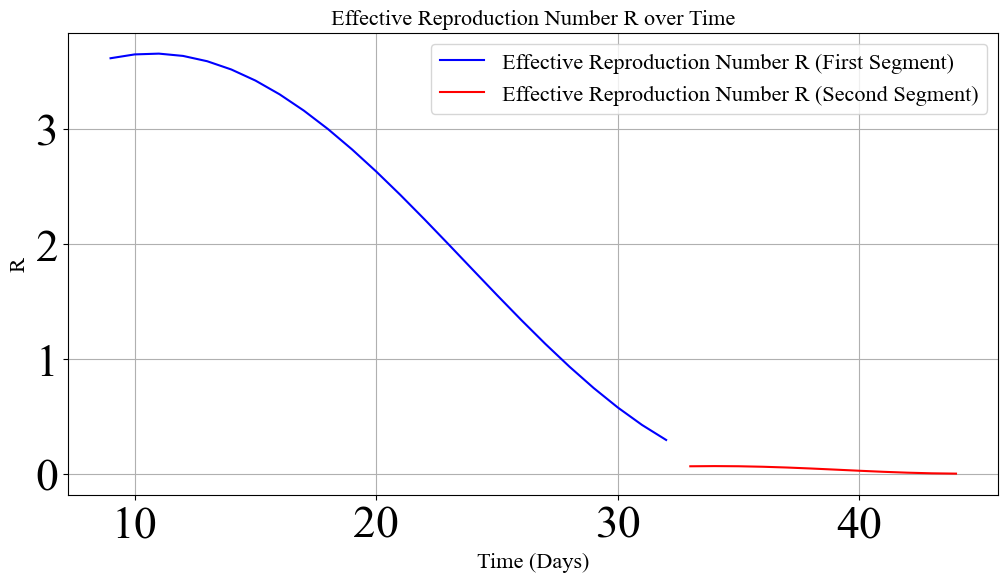

In [ ]:
N1 = 4395300



def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    

    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    

    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    

    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(9, 33)

R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics


median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2020 的中位数:", median_R_1)
print("R_2020 的中位数:", median_R_2)


plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

result_2020 = np.concatenate((result_1.best_fit, result_2.best_fit))


observed_cases_2020 = I_2020[8:44].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2020


y_pred = result_2020  


mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')


rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')


mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')


mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')


r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 2.8780818184992305
RMSE: 1.6964910310694927
R-squared: 0.38039966166528205
MAE: 1.3476110817306437
MAPE: inf%


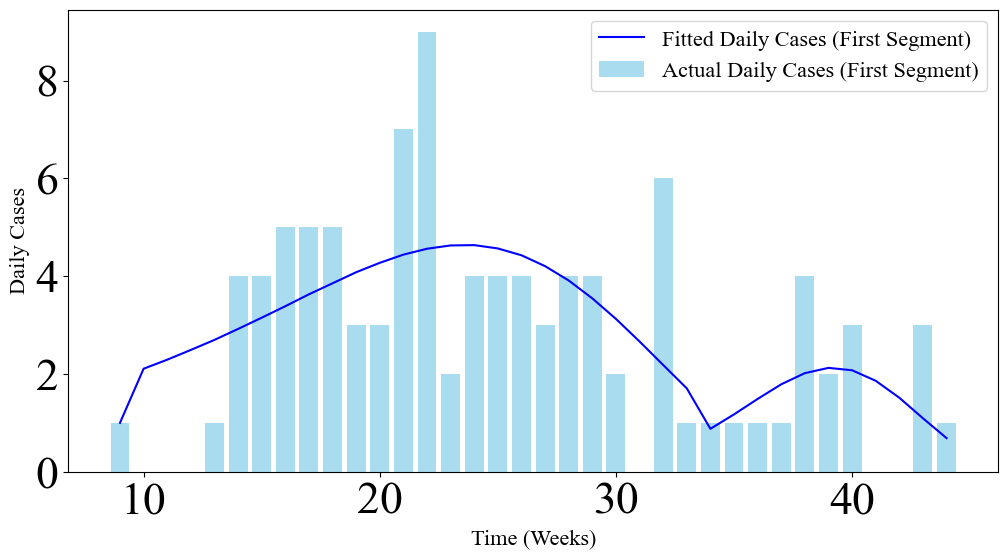

皮尔森相关系数：0.6200734410172456
p值：5.494594097753927e-05


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(9, 45), observed_cases_2020, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(9, 45), result_2020, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Luan/2020.pdf', format='pdf')
plt.show()


from scipy.stats import pearsonr


corr, p_value = pearsonr(observed_cases_2020, result_2020)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

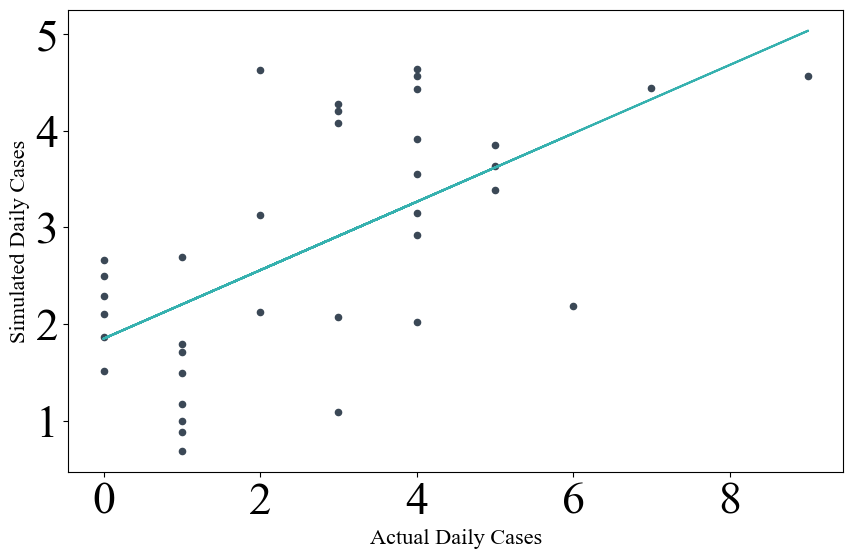

R²：0.3844910722549678


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  


I_obs = np.array(observed_cases_2020)
predicted_cases = np.array(result_2020)


model = LinearRegression()


model.fit(I_obs.reshape(-1, 1), predicted_cases)


y_pred = model.predict(I_obs.reshape(-1, 1))


r2 = r2_score(predicted_cases, y_pred)


plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Luan/2020.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.2348096940832194
R_2023 的平均数为: 1.552394543772306


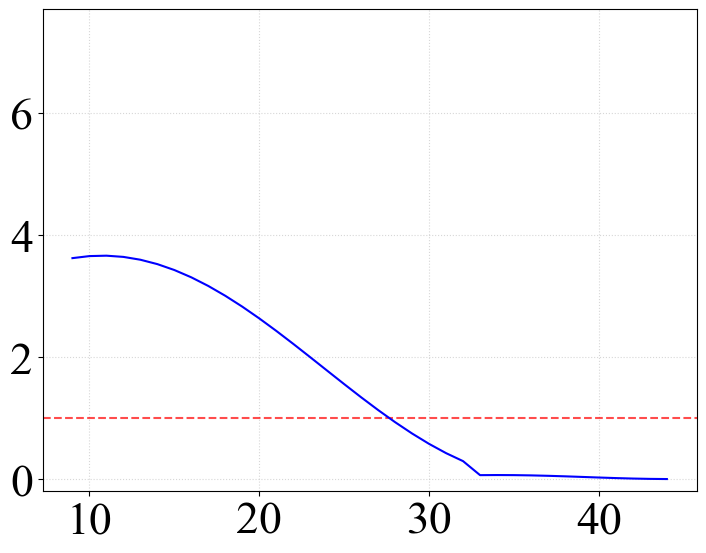

In [ ]:
R_2020 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2020).to_excel('../../outcome/Result/Fit/Luan/R_2020.xlsx', index=False)

import statistics

median_Rt_11 = statistics.median(R_2020)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2020)
print(f"R_2023 的平均数为: {average_R}")

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 

plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')

plt.ylim(-0.2, 7.7)
plt.yticks(np.arange(0, 7.1, 2))  
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.plot(np.arange(9, 45), R_2020, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Luan/R_2020.pdf', format='pdf')
plt.show()

## 2019

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 22
    # variables        = 4
    chi-square         = 73.3727907
    reduced chi-square = 4.07626615
    Akaike info crit   = 34.4992357
    Bayesian info crit = 38.8634055
    R-squared          = 0.21335215
[[Variables]]
    beta0:  0.05704925 +/- 0.23189879 (406.49%) (init = 0.001)
    alpha: -1.72481307 +/- 33.8193010 (1960.75%) (init = 2)
    T:      52 (fixed)
    S2_0:   3002.59471 +/- 185433.296 (6175.77%) (init = 5000)
    S3_0:   3244.25431 +/- 66349135.2 (2045127.44%) (init = 5000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S3_0)  = +0.9804
    C(S2_0, S3_0)   = +0.9782
    C(beta0, S2_0)  = +0.9186
    C(beta0, alpha) = -0.8875
    C(alpha, S3_0)  = -0.7854
    C(alpha, S2_0)  = -0.6406
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # da

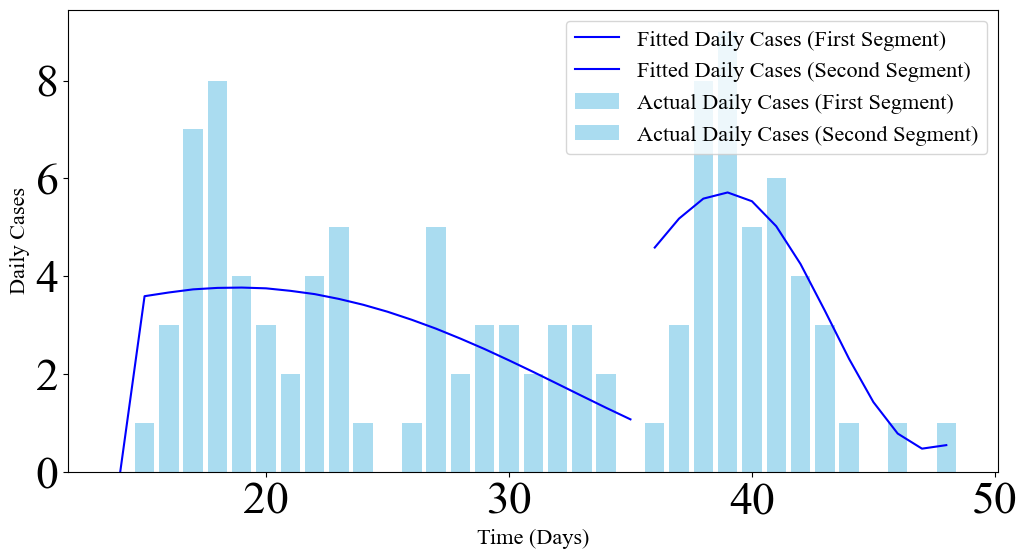

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters


def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))


def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]


observed_cases_1 = I_2019[13:35].reset_index(drop=True).values  
observed_cases_2 = I_2019[35:48].reset_index(drop=True).values  
t_days_1 = np.arange(14, 36)  
t_days_2 = np.arange(35, 49)  
t_days_3 = np.arange(36, 49)  


def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4872999  
    I1_0 = 1        
    E1_0 = 0        
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.01228
    dr1 = 0.00623
    κ = 1
    p = 0.043
    f = 0.009434
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))


model = Model(model_fit)


params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  
params.add('alpha', value=2, min=-10, max=10)       
params.add('T', value=52, vary=False)               
params.add('S2_0', value=5000, min=3000, max=1e5)  
params.add('S3_0', value=5000, min=3000, max=1e4)  


result_1 = model.fit(observed_cases_1, params, t=t_days_1)


S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value


initial_state_segment1 = [
    4872999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.01228
dr1 = 0.00623
κ = 1
p = 0.043
f = 0.009434
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))


final_state_segment1 = result_segment1.y[:, -1]


def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.01228
    dr1 = 0.00623
    κ = 1
    p = 0.043
    f = 0.009434
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt


model_segment2 = Model(model_fit_segment2)


params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  
# params_segment2.add('T', value=52, vary=False) 


result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)


print(result_1.fit_report())
print(result_2.fit_report())


plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2020 的中位数: 1.3954835770882257
R_2020 的中位数: 0.032878431412391065


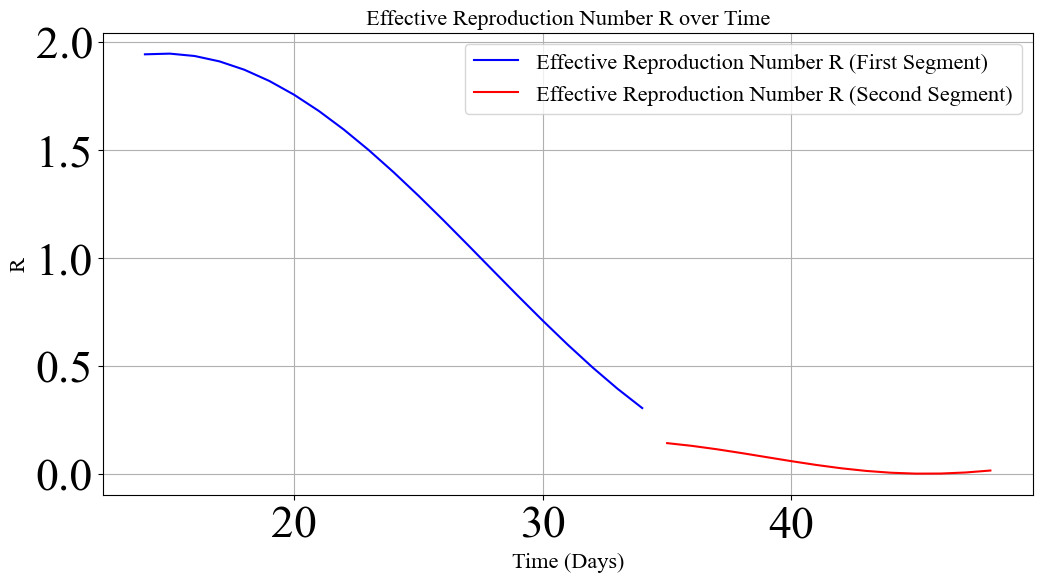

In [ ]:
N1 = 4873000



def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    

    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    

    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    

    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(14, 35)

R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics


median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2020 的中位数:", median_R_1)
print("R_2020 的中位数:", median_R_2)


plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

result_2019 = np.concatenate((result_1.best_fit, result_2.best_fit))


observed_cases_2019 = I_2019[13:48].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2019


y_pred = result_2019  


mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')


rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')


mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')


mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')


r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 3.2344288000510737
RMSE: 1.7984517786282384
R-squared: 0.44226136260380566
MAE: 1.3984066423579744
MAPE: nan%


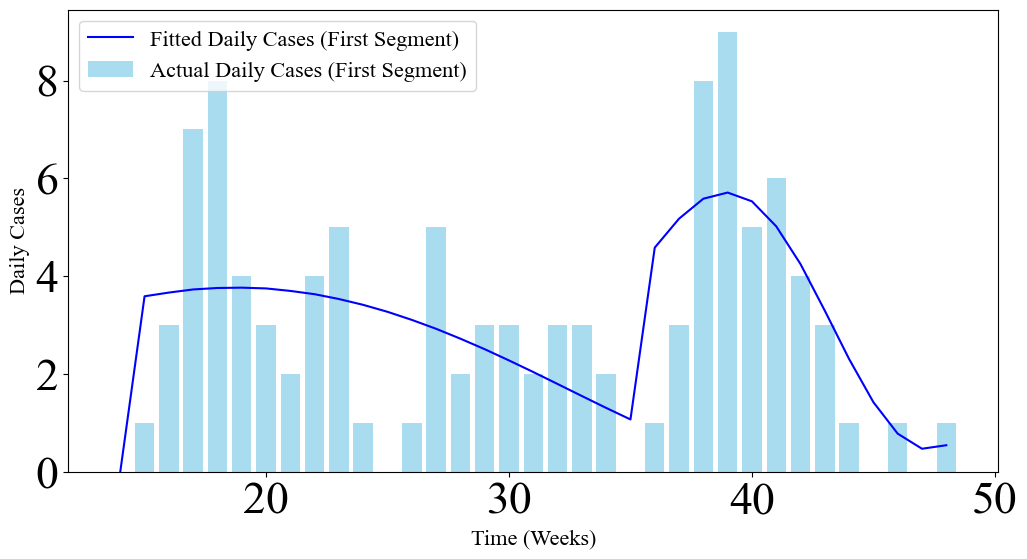

皮尔森相关系数：0.6666980282165613
p值：1.2261617880283594e-05


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(14, 49), observed_cases_2019, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(14, 49), result_2019, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Luan/2019.pdf', format='pdf')
plt.show()


from scipy.stats import pearsonr


corr, p_value = pearsonr(observed_cases_2019, result_2019)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

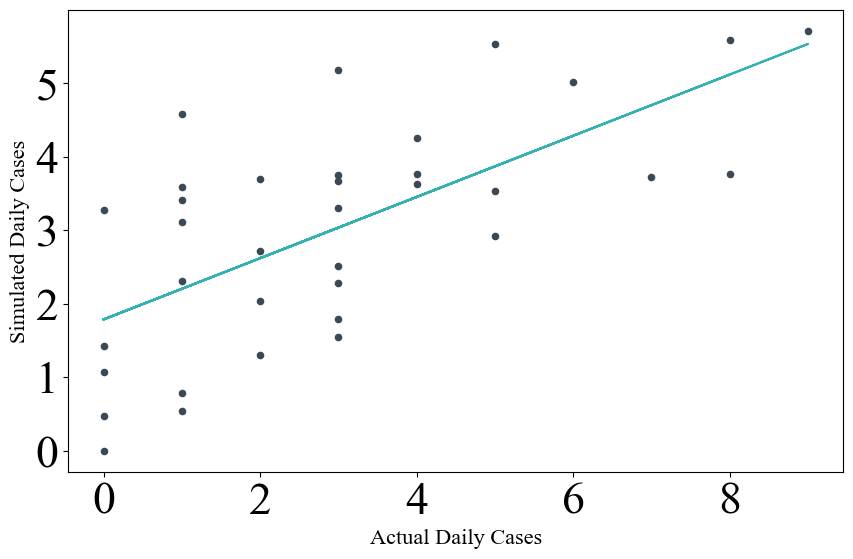

R²：0.4444862608278507


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  


I_obs = np.array(observed_cases_2019)
predicted_cases = np.array(result_2019)


model = LinearRegression()


model.fit(I_obs.reshape(-1, 1), predicted_cases)


y_pred = model.predict(I_obs.reshape(-1, 1))


r2 = r2_score(predicted_cases, y_pred)


plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()

plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Luan/2019.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 0.5975723710366203
R_2023 的平均数为: 0.795121016043988


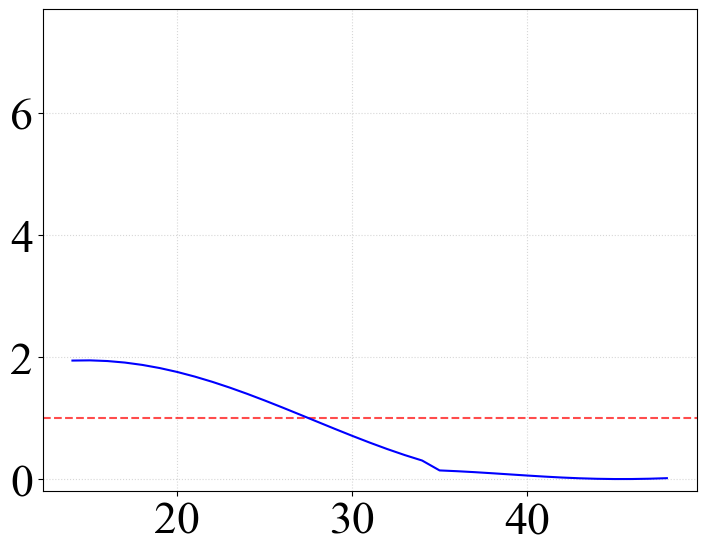

In [ ]:
R_2019 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2019).to_excel('../../outcome/Result/Fit/Luan/R_2019.xlsx', index=False)

import statistics

median_Rt_11 = statistics.median(R_2019)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2019)
print(f"R_2023 的平均数为: {average_R}")

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 

plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')

plt.ylim(-0.2, 7.7)
plt.yticks(np.arange(0, 7.1, 2))  
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.plot(np.arange(14, 49), R_2019, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
# plt.legend()
# # plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Luan/R_2019.pdf', format='pdf')
plt.show()